In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# 한글 폰트 설정 (환경에 맞게 글꼴명 또는 경로를 수정)
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False  # 음수 기호 깨짐 방지

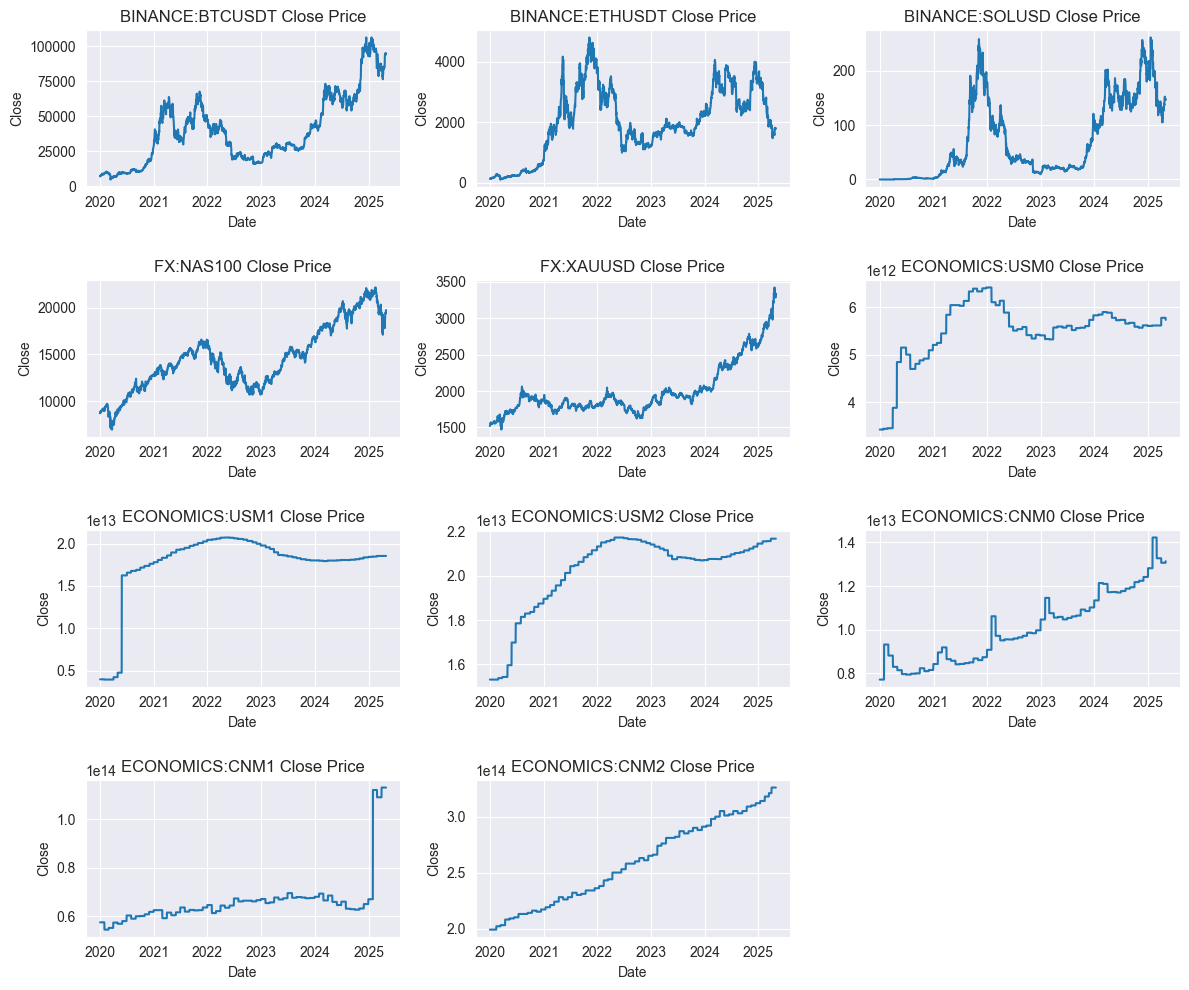

=== Weekly Correlation Top 10 (USM·CNM 제외) ===
       Symbol 1        Symbol 2  Correlation
BINANCE:BTCUSDT BINANCE:ETHUSDT     0.774034
BINANCE:ETHUSDT  BINANCE:SOLUSD     0.603243
BINANCE:BTCUSDT  BINANCE:SOLUSD     0.519148
BINANCE:ETHUSDT       FX:NAS100     0.362967
BINANCE:BTCUSDT       FX:NAS100     0.296511
 BINANCE:SOLUSD       FX:NAS100     0.209996
      FX:NAS100       FX:XAUUSD     0.178270
BINANCE:ETHUSDT  ECONOMICS:USM2     0.104979
BINANCE:BTCUSDT  ECONOMICS:USM0     0.102109
BINANCE:BTCUSDT       FX:XAUUSD     0.094576

=== Monthly Correlation Top 10 (USM·CNM 제외) ===
       Symbol 1        Symbol 2  Correlation
BINANCE:BTCUSDT BINANCE:ETHUSDT     0.748650
BINANCE:ETHUSDT       FX:NAS100     0.634017
BINANCE:ETHUSDT  BINANCE:SOLUSD     0.611708
BINANCE:BTCUSDT       FX:NAS100     0.511571
BINANCE:BTCUSDT  BINANCE:SOLUSD     0.448414
      FX:NAS100  ECONOMICS:USM0     0.405664
 BINANCE:SOLUSD       FX:NAS100     0.384384
BINANCE:ETHUSDT  ECONOMICS:USM0     0.375856
BINA

C:\Users\kmj\AppData\Local\Temp\ipykernel_19336\4137886385.py:54: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = close_df.resample('M').last().pct_change().dropna()


In [10]:
# Step 1: 라이브러리 임포트 및 심볼 정의
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

symbols = [
    "BINANCE:BTCUSDT", "BINANCE:ETHUSDT", "BINANCE:SOLUSD",
    "FX:NAS100", "FX:XAUUSD",
    "ECONOMICS:USM0", "ECONOMICS:USM1", "ECONOMICS:USM2",
    "ECONOMICS:CNM0", "ECONOMICS:CNM1", "ECONOMICS:CNM2"
]
data = {}

# --- CSV 파일 로드 (data 채우기) ---
for sym in symbols:
    filepath = f"./chart/{sym.replace(':', '_')}_daily_UTC.csv"
    if not os.path.exists(filepath):
        continue

    df = pd.read_csv(filepath, parse_dates=['date'])
    df = df.drop_duplicates(subset='date').sort_values('date').set_index('date')
    data[sym] = df

# 여기서 available_symbols 정의
available_symbols = list(data.keys())

# === 수정된 Step 2: 하나의 Figure에 여러 Subplot으로 그리기 ===
sns.set_style("darkgrid")
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))
axes = axes.flatten()

for i, sym in enumerate(available_symbols):
    df = data[sym]
    sns.lineplot(x=df.index, y=df['close'], ax=axes[i])
    axes[i].set_title(f"{sym} Close Price")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Close")

for j in range(len(available_symbols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Step 3: 종가만 모아서 하나의 DataFrame으로 결합
# 파일이 로드된 심볼들만 사용
available_symbols = list(data.keys())
close_df = pd.DataFrame({sym: data[sym]['close'] for sym in available_symbols})

# Step 4: 주간 및 월간 수익률 계산
weekly_returns = close_df.resample('W').last().pct_change().dropna()
monthly_returns = close_df.resample('M').last().pct_change().dropna()

# Step 5: 상관계수 행렬 계산
weekly_corr = weekly_returns.corr()
monthly_corr = monthly_returns.corr()

# Step 6: 상관계수 행렬을 쌍별로 펼쳐서 랭킹 생성
def flatten_corr(corr_df):
    pairs = []
    syms = corr_df.columns.tolist()
    for i in range(len(syms)):
        for j in range(i+1, len(syms)):
            pairs.append({
                'Symbol 1': syms[i],
                'Symbol 2': syms[j],
                'Correlation': corr_df.iloc[i, j]
            })
    return pd.DataFrame(pairs)

weekly_pairs = flatten_corr(weekly_corr).sort_values('Correlation', ascending=False)
monthly_pairs = flatten_corr(monthly_corr).sort_values('Correlation', ascending=False)

# Step 7: USM끼리, CNM끼리는 제외
def exclude_same_group(df):
    mask_usm = df['Symbol 1'].str.startswith("ECONOMICS:USM") & df['Symbol 2'].str.startswith("ECONOMICS:USM")
    mask_cnm = df['Symbol 1'].str.startswith("ECONOMICS:CNM") & df['Symbol 2'].str.startswith("ECONOMICS:CNM")
    return df[~(mask_usm | mask_cnm)]

weekly_pairs = exclude_same_group(weekly_pairs).sort_values('Correlation', ascending=False)
monthly_pairs = exclude_same_group(monthly_pairs).sort_values('Correlation', ascending=False)

# Step 8: 결과 출력 (상위 10개만 예시로 출력)
print("=== Weekly Correlation Top 10 (USM·CNM 제외) ===")
print(weekly_pairs.head(10).to_string(index=False))
print("\n=== Monthly Correlation Top 10 (USM·CNM 제외) ===")
print(monthly_pairs.head(10).to_string(index=False))

# 필요하면 CSV로 저장
# weekly_pairs.to_csv("weekly_correlation_rankings.csv", index=False)
# monthly_pairs.to_csv("monthly_correlation_rankings.csv", index=False)


핵심 정리
암호화폐 내에서 가장 밀접하게 움직이는 쌍은

BTC⇄ETH (가장 높은 상관)

ETH⇄SOL, BTC⇄SOL

암호화폐⇄주식지수(나스닥) 간에도 꽤 높은 상관이 관찰됩니다. (특히 이더리움과 나스닥)

**금(FX:XAUUSD)**과 암호화폐·주식지수 간에는 중간 정도 수준의 상관이 존재하며,

미국 통화지표(USM0·USM1·USM2)끼리의 비교는 의도적으로 배제되어 있습니다.

따라서, 주간 또는 월간 단위로 가장 강하게 움직임이 동조하는 자산쌍을 정리하면 위 표와 같으며, 이를 통해 비트코인을 예측할 때는 특히 **이더리움(ETH)**과 솔라나(SOL), 그리고 **나스닥 지수(NAS100)**의 움직임이 중요한 참고 지표가 될 수 있음을 알 수 있습니다.

=== Weekly Top 10 Correlations (USM·CNM 제외) ===
BTCUSDT ↔ ETHUSDT: 0.7740
ETHUSDT ↔ SOLUSD: 0.6032
BTCUSDT ↔ SOLUSD: 0.5191
ETHUSDT ↔ NAS100: 0.3630
BTCUSDT ↔ NAS100: 0.2965
SOLUSD ↔ NAS100: 0.2100
NAS100 ↔ XAUUSD: 0.1783
ETHUSDT ↔ USM2: 0.1050
BTCUSDT ↔ USM0: 0.1021
BTCUSDT ↔ XAUUSD: 0.0946

=== Monthly Top 10 Correlations (USM·CNM 제외) ===
BTCUSDT ↔ ETHUSDT: 0.7486
ETHUSDT ↔ NAS100: 0.6340
ETHUSDT ↔ SOLUSD: 0.6117
BTCUSDT ↔ NAS100: 0.5116
BTCUSDT ↔ SOLUSD: 0.4484
NAS100 ↔ USM0: 0.4057
SOLUSD ↔ NAS100: 0.3844
ETHUSDT ↔ USM0: 0.3759
BTCUSDT ↔ USM0: 0.3510
SOLUSD ↔ USM0: 0.2490


C:\Users\kmj\AppData\Local\Temp\ipykernel_19336\634820404.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


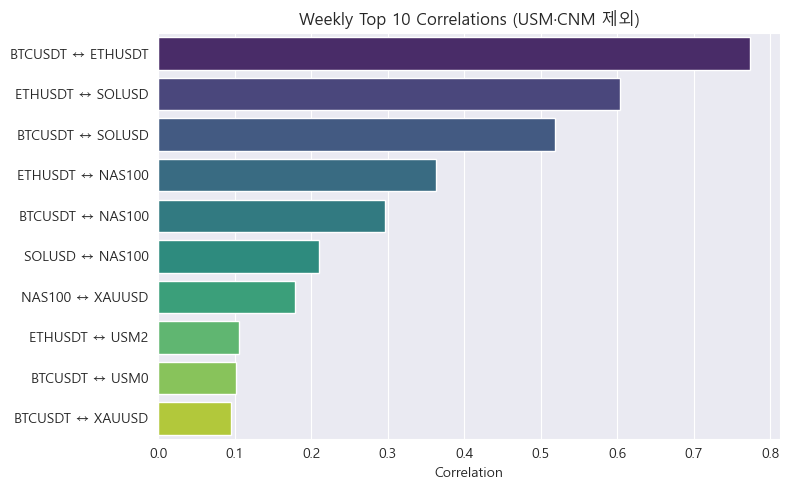

C:\Users\kmj\AppData\Local\Temp\ipykernel_19336\634820404.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


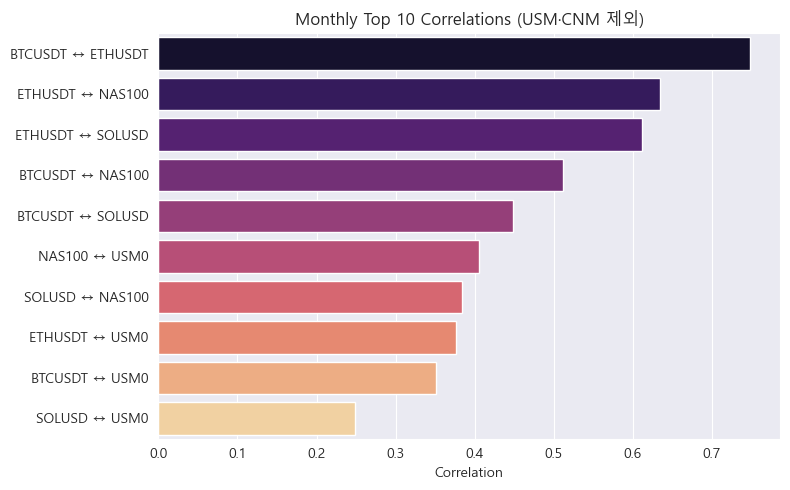

In [16]:
# --- 1) 상위 10개 데이터 추출 ---
top_w = weekly_pairs.head(10).copy()
top_m = monthly_pairs.head(10).copy()

# 막대그래프용으로 “Symbol 1 vs Symbol 2” 문자열 컬럼 추가
top_w['Pair'] = top_w['Symbol 1'].str.split(':').str[-1] + " ↔ " + top_w['Symbol 2'].str.split(':').str[-1]
top_m['Pair'] = top_m['Symbol 1'].str.split(':').str[-1] + " ↔ " + top_m['Symbol 2'].str.split(':').str[-1]

# --- 1.5) 글자로도 결과 출력 ---
print("=== Weekly Top 10 Correlations (USM·CNM 제외) ===")
for _, row in top_w.iterrows():
    print(f"{row['Pair']}: {row['Correlation']:.4f}")

print("\n=== Monthly Top 10 Correlations (USM·CNM 제외) ===")
for _, row in top_m.iterrows():
    print(f"{row['Pair']}: {row['Correlation']:.4f}")

# --- 2) Weekly 상위 10 막대그래프 ---
plt.figure(figsize=(8, 5))
sns.barplot(
    data=top_w,
    x='Correlation',
    y='Pair',
    palette='viridis'
)
plt.title("Weekly Top 10 Correlations (USM·CNM 제외)")
plt.xlabel("Correlation")
plt.ylabel("")
plt.tight_layout()
plt.show()

# --- 3) Monthly 상위 10 막대그래프 ---
plt.figure(figsize=(8, 5))
sns.barplot(
    data=top_m,
    x='Correlation',
    y='Pair',
    palette='magma'
)
plt.title("Monthly Top 10 Correlations (USM·CNM 제외)")
plt.xlabel("Correlation")
plt.ylabel("")
plt.tight_layout()
plt.show()


C:\Users\kmj\AppData\Local\Temp\ipykernel_4852\2676431416.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  usm1_monthly = usm1_daily.resample('M').last()


Test RMSE: 0.081794
Test R²: -0.6313

Feature Importances:
rollcorr_cnm1             0.369609
rollcorr_usm1             0.323151
ECONOMICS:CNM2_cnm_pct    0.133520
ECONOMICS:CNM0_cnm_pct    0.044425
ECONOMICS:USM0_usm_pct    0.033338
ECONOMICS:USM1_usm_pct    0.032158
ECONOMICS:CNM1_cnm_pct    0.027422
ECONOMICS:USM2_usm_pct    0.026914
regime                    0.009463


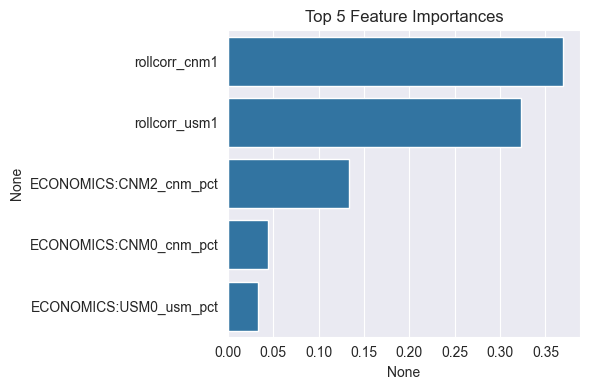

In [12]:
# predict_btc_with_macro.py

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 1. 심볼 목록 정의 및 데이터 로드
symbols = [
    "BINANCE:BTCUSDT", "BINANCE:ETHUSDT", "BINANCE:SOLUSD",
    "FX:NAS100", "FX:XAUUSD",
    "ECONOMICS:USM0", "ECONOMICS:USM1", "ECONOMICS:USM2",
    "ECONOMICS:CNM0", "ECONOMICS:CNM1", "ECONOMICS:CNM2"
]
data = {}
for sym in symbols:
    filepath = f"./chart/{sym.replace(':','_')}_daily_UTC.csv"
    if not os.path.exists(filepath):
        continue
    df = pd.read_csv(filepath, parse_dates=['date'])
    df = df.drop_duplicates(subset='date').sort_values('date').set_index('date')
    data[sym] = df

# 2. 종가(close)만 모아서 하나의 DataFrame
available_symbols = list(data.keys())
close_df = pd.DataFrame({sym: data[sym]['close'] for sym in available_symbols})

# 3. 주간 수익률(Weekly Returns) 계산
weekly_returns = close_df.resample('W').last().pct_change().dropna()

# 4. USM/CNM 주간 변화율(ΔUSM, ΔCNM) 피처 생성
usm_cols = [c for c in weekly_returns.columns if c.startswith("ECONOMICS:USM")]
cnm_cols = [c for c in weekly_returns.columns if c.startswith("ECONOMICS:CNM")]

usm_weekly = weekly_returns[usm_cols]
cnm_weekly = weekly_returns[cnm_cols]

# 5. 레짐 변수 생성:
#    USM1 월간 변화율 > 5% → 긴축(1), 아니면 0
usm1_daily = data['ECONOMICS:USM1']['close'].sort_index()
usm1_monthly = usm1_daily.resample('M').last()
usm1_monthly_pct = usm1_monthly.pct_change()
regime_monthly = (usm1_monthly_pct > 0.05).astype(int)         # Series
regime_weekly = regime_monthly.resample('W').ffill().reindex(weekly_returns.index).fillna(0)

# 6. 롤링 상관계수 피처 (4주 윈도우) between USM1↔BTC, CNM1↔BTC
btc_weekly = weekly_returns['BINANCE:BTCUSDT']
rolling_corr_usm1 = usm_weekly['ECONOMICS:USM1'].rolling(window=4).corr(btc_weekly)
rolling_corr_cnm1 = cnm_weekly['ECONOMICS:CNM1'].rolling(window=4).corr(btc_weekly)

# 7. 피처 데이터프레임 병합
features = pd.concat([
    usm_weekly.add_suffix('_usm_pct'),
    cnm_weekly.add_suffix('_cnm_pct'),
    regime_weekly.rename('regime'),
    rolling_corr_usm1.rename('rollcorr_usm1'),
    rolling_corr_cnm1.rename('rollcorr_cnm1')
], axis=1).dropna()

# 8. Target: 다음 주 BTC 수익률 (shift -1)
features['btc_ret_next'] = btc_weekly.shift(-1)
features = features.dropna()

# 9. 학습/검증 데이터 분리
X = features.drop(columns=['btc_ret_next'])
y = features['btc_ret_next']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# 10. 모델 학습 (RandomForestRegressor)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 11. 예측 및 성능 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.6f}")
print(f"Test R²: {r2:.4f}")

# 12. 피처 중요도 출력
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)
print("\nFeature Importances:")
print(importances.to_string())

# 13. (옵션) 중요도 상위 5개 시각화
plt.figure(figsize=(6,4))
sns.barplot(x=importances.head(5), y=importances.head(5).index)
plt.title("Top 5 Feature Importances")
plt.tight_layout()
plt.show()


C:\Users\kmj\AppData\Local\Temp\ipykernel_4852\3186897929.py:44: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  usm1_monthly = usm1_daily.resample('M').last()


Test RMSE: 0.081794
Test R²: -0.6313

Feature Importances:
 rollcorr_cnm1             0.369609
rollcorr_usm1             0.323151
ECONOMICS:CNM2_cnm_pct    0.133520
ECONOMICS:CNM0_cnm_pct    0.044425
ECONOMICS:USM0_usm_pct    0.033338
ECONOMICS:USM1_usm_pct    0.032158
ECONOMICS:CNM1_cnm_pct    0.027422
ECONOMICS:USM2_usm_pct    0.026914
regime                    0.009463

=== Macro Feature Averages for Large Moves ===
            ECONOMICS:USM0_usm_pct  ECONOMICS:USM1_usm_pct  ECONOMICS:USM2_usm_pct  ECONOMICS:CNM0_cnm_pct  ECONOMICS:CNM1_cnm_pct  ECONOMICS:CNM2_cnm_pct    regime  rollcorr_usm1  rollcorr_cnm1  btc_ret_next
category                                                                                                                                                                                                        
large_up                  0.012294                0.007085                0.002618                0.007679               -0.005795                0.002041  0.0

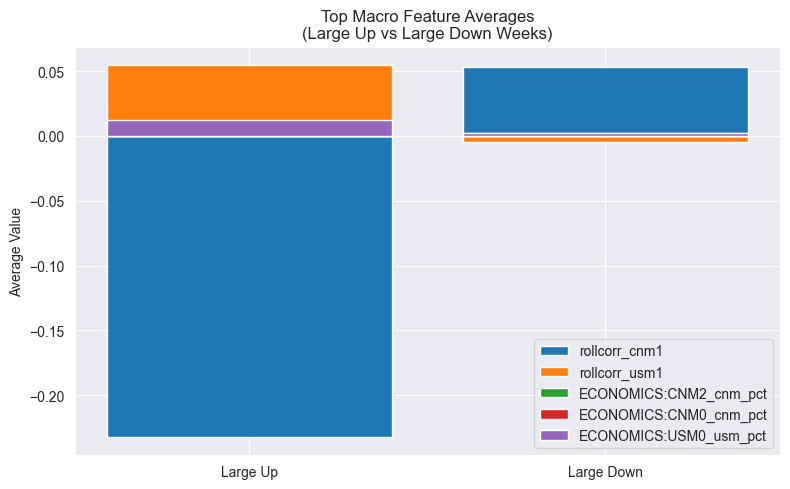

In [13]:
# predict_btc_with_macro_analysis.py

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 1. 심볼 목록 정의 및 데이터 로드
symbols = [
    "BINANCE:BTCUSDT", "BINANCE:ETHUSDT", "BINANCE:SOLUSD",
    "FX:NAS100", "FX:XAUUSD",
    "ECONOMICS:USM0", "ECONOMICS:USM1", "ECONOMICS:USM2",
    "ECONOMICS:CNM0", "ECONOMICS:CNM1", "ECONOMICS:CNM2"
]
data = {}
for sym in symbols:
    filepath = f"./chart/{sym.replace(':','_')}_daily_UTC.csv"
    if not os.path.exists(filepath):
        continue
    df = pd.read_csv(filepath, parse_dates=['date'])
    df = df.drop_duplicates(subset='date').sort_values('date').set_index('date')
    data[sym] = df

# 2. 종가(close)만 모아서 하나의 DataFrame
available_symbols = list(data.keys())
close_df = pd.DataFrame({sym: data[sym]['close'] for sym in available_symbols})

# 3. 주간 수익률(Weekly Returns) 계산
weekly_returns = close_df.resample('W').last().pct_change().dropna()

# 4. USM/CNM 주간 변화율(ΔUSM, ΔCNM) 피처 생성
usm_cols = [c for c in weekly_returns.columns if c.startswith("ECONOMICS:USM")]
cnm_cols = [c for c in weekly_returns.columns if c.startswith("ECONOMICS:CNM")]

usm_weekly = weekly_returns[usm_cols]
cnm_weekly = weekly_returns[cnm_cols]

# 5. 레짐 변수 생성
usm1_daily = data['ECONOMICS:USM1']['close'].sort_index()
usm1_monthly = usm1_daily.resample('M').last()
usm1_monthly_pct = usm1_monthly.pct_change()
regime_monthly = (usm1_monthly_pct > 0.05).astype(int)
regime_weekly = regime_monthly.resample('W').ffill().reindex(weekly_returns.index).fillna(0)

# 6. 롤링 상관계수 피처 (4주 윈도우) between USM1↔BTC, CNM1↔BTC
btc_weekly = weekly_returns['BINANCE:BTCUSDT']
rolling_corr_usm1 = usm_weekly['ECONOMICS:USM1'].rolling(window=4).corr(btc_weekly)
rolling_corr_cnm1 = cnm_weekly['ECONOMICS:CNM1'].rolling(window=4).corr(btc_weekly)

# 7. 피처 데이터프레임 병합
features = pd.concat([
    usm_weekly.add_suffix('_usm_pct'),
    cnm_weekly.add_suffix('_cnm_pct'),
    regime_weekly.rename('regime'),
    rolling_corr_usm1.rename('rollcorr_usm1'),
    rolling_corr_cnm1.rename('rollcorr_cnm1')
], axis=1).dropna()

# 8. Target: 다음 주 BTC 수익률 (shift -1)
features['btc_ret_next'] = btc_weekly.shift(-1)
features = features.dropna()

# 9. 학습/검증 데이터 분리 (모델 학습 부분은 생략)
X = features.drop(columns=['btc_ret_next'])
y = features['btc_ret_next']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.6f}")
print(f"Test R²: {r2:.4f}")
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances:\n", importances.head(10).to_string())

# 10. 큰 상승/하락 구간과 매크로 피처 연관 분석
#   - 상위 10% 수익률: 'large_up'
#   - 하위 10% 수익률: 'large_down'
threshold_high = btc_weekly.quantile(0.90)
threshold_low  = btc_weekly.quantile(0.10)

# 카테고리 레이블 생성
labels = pd.Series(index=btc_weekly.index, dtype="object")
labels[btc_weekly >= threshold_high] = 'large_up'
labels[btc_weekly <= threshold_low]  = 'large_down'
labels[(btc_weekly > threshold_low) & (btc_weekly < threshold_high)] = 'normal'

# features에서 해당 주와 매칭되는 부분만 추출
features_analysis = features.copy()
features_analysis['category'] = labels.reindex(features.index)

# 'large_up'과 'large_down'의 평균 매크로 피처 값 계산
group_means = features_analysis.groupby('category').mean().loc[['large_up', 'large_down']]

print("\n=== Macro Feature Averages for Large Moves ===")
print(group_means.to_string())

# 11. 시각화: 피처별 평균 비교 (Select top features)
top_feats = importances.head(5).index.tolist()
plt.figure(figsize=(8, 5))
for feat in top_feats:
    plt.bar(['Large Up', 'Large Down'],
            [group_means.loc['large_up', feat], group_means.loc['large_down', feat]],
            label=feat)
plt.title("Top Macro Feature Averages\n(Large Up vs Large Down Weeks)")
plt.ylabel("Average Value")
plt.legend()
plt.tight_layout()
plt.show()


결론

큰 상승과 관련해서는

미국·중국 통화량(USM0, USM1, CNM0, CNM2)의 주간 증가 폭이 커서 매크로 확장 신호가 강했던 주에 BTC가 급등하는 경향이 있습니다.

특히 중국 M1(CNM1)이 크게 줄어든 반면(-0.58%), 미국 M1(USM1)은 늘어난(0.71%) 구간에서 대규모 상승이 발생했습니다.

4주 롤링 상관으로 보면, 큰 상승 시 USM1↔BTC는 양(+) 상관, CNM1↔BTC는 음(–) 상관이었기 때문에 “미국 통화량 확장 vs 중국 통화량 축소” 기조가 BTC 상승을 촉진한 것으로 보입니다.

큰 하락과 관련해서는

전반적으로 USM·CNM 변화율이 작은 구간(USM0 0.23%, USM1 0.13%, CNM0 0.22%, CNM2 0.02%)이었고

최근 4주 상관에서는 CNM1↔BTC가 소폭 양(+)으로 나타나 “중국 통화량 축소가 미미하게 BTC와 함께 움직인” 양상이었습니다.

어떤 특정 매크로 기조(확장·축소)가 두드러지지 않은 상태에서 BTC가 크게 하락한 것으로 보이며, USM1↔BTC 상관이 거의 0에 가까워 매크로와는 무관하게 다른 요인(예: 암호화폐 시장 자체 펀더멘털, 규제 뉴스 등)이 영향을 주었을 가능성이 있습니다.

따라서, 커다란 상승 구간은 “미국 통화량 확장(특히 USM1 상승폭 큼) + 중국 통화량 축소(특히 CNM1 감소폭 큼)”과 맞물려 발생했고, 커다란 하락 구간은 매크로 신호가 뚜렷하지 않았다고 요약할 수 있습니다.

In [14]:
# (predict_btc_with_macro.py 상단에 추가)
for sym, df in data.items():
    print(f"{sym} date range: {df.index.min().date()} ~ {df.index.max().date()}")

BINANCE:BTCUSDT date range: 2020-01-01 ~ 2025-04-30
BINANCE:ETHUSDT date range: 2020-01-01 ~ 2025-04-30
BINANCE:SOLUSD date range: 2020-01-01 ~ 2025-04-30
FX:NAS100 date range: 2020-01-01 ~ 2025-04-30
FX:XAUUSD date range: 2020-01-01 ~ 2025-04-30
ECONOMICS:USM0 date range: 2020-01-01 ~ 2025-04-30
ECONOMICS:USM1 date range: 2020-01-01 ~ 2025-04-30
ECONOMICS:USM2 date range: 2020-01-01 ~ 2025-04-30
ECONOMICS:CNM0 date range: 2020-01-01 ~ 2025-04-30
ECONOMICS:CNM1 date range: 2020-01-01 ~ 2025-04-30
ECONOMICS:CNM2 date range: 2020-01-01 ~ 2025-04-30


c:\Users\kmj\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


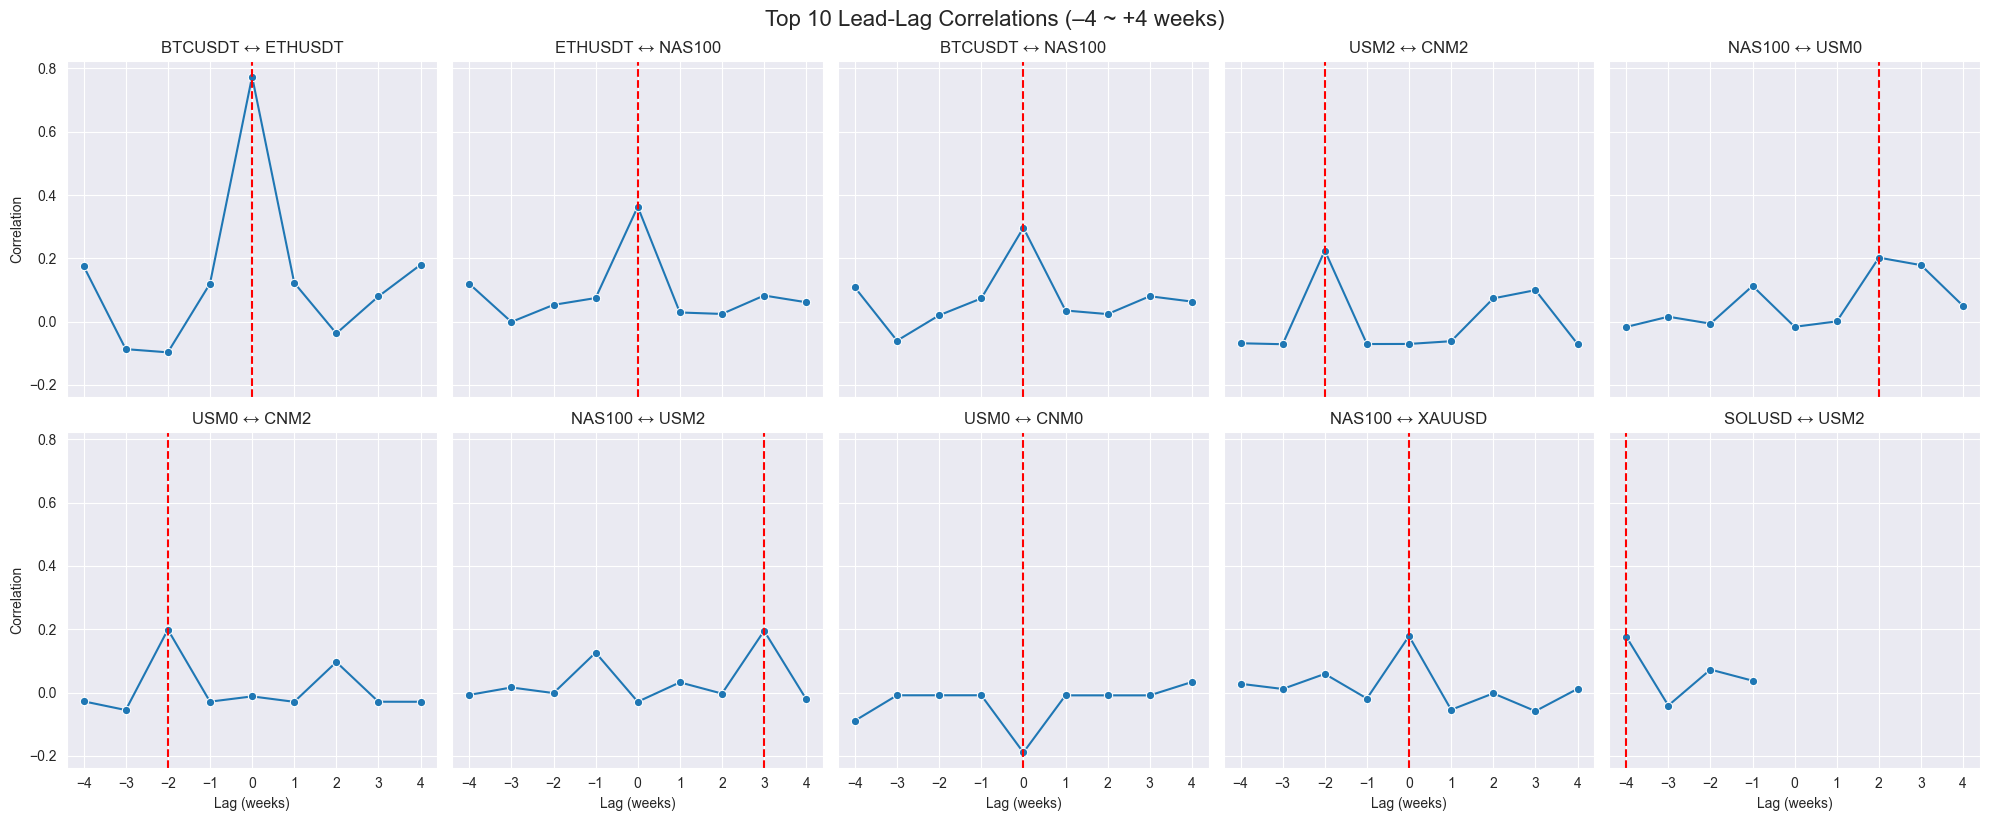

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) lag_df_filtered가 이미 계산되었다고 가정
# 절대값 기준으로 정렬된 lag_df_filtered에서 상위 10개 페어 추출
top_n = 10
top_pairs = lag_df_filtered.head(top_n).reset_index(drop=True)

# 2) 서브플롯 개수 설정 (예: 2행 x 5열)
n_rows = 2
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8), sharex=True, sharey=True)

# 3) 각 페어에 대해 시차별 상관계수 계산 후 시각화
for idx, row in top_pairs.iterrows():
    s1 = row['Symbol 1']
    s2 = row['Symbol 2']
    ax = axes[idx // n_cols][idx % n_cols]
    
    # 두 자산의 주간 수익률 Series
    series1 = weekly_returns[s1]
    series2 = weekly_returns[s2]
    
    # –4주부터 +4주까지 상관계수 계산
    lags = list(range(-4, 5))
    corrs = [series1.shift(l).corr(series2) for l in lags]
    
    # 선 그래프
    sns.lineplot(x=lags, y=corrs, marker='o', ax=ax)
    
    # 최적 시차 (best lag) 표시
    best_lag = int(row['Best_Lag (weeks)'])
    ax.axvline(best_lag, color='red', linestyle='--')
    
    # 타이틀: e.g. "BTC ↔ ETH"
    ax.set_title(f"{s1.split(':')[-1]} ↔ {s2.split(':')[-1]}")
    if idx % n_cols == 0:
        ax.set_ylabel("Correlation")
    if idx // n_cols == n_rows - 1:
        ax.set_xlabel("Lag (weeks)")
    ax.set_xticks(lags)

# 4) 레이아웃 정리 및 출력
plt.tight_layout()
plt.suptitle("Top 10 Lead-Lag Correlations (–4 ~ +4 weeks)", y=1.02, fontsize=16)
plt.show()


종합 정리

암호화폐 간(특히 BTC ↔ ETH)에는 매우 강한 동시 상관(시차 0)이 존재하여, 한쪽이 움직이면 즉각 다른 쪽이 같은 방향으로 크게 반응.

암호화폐 ↔ 전통 시장(NAS100) 관계도 시차 0에서 약하게나마 동조되며, 크립토보다는 상관도가 낮은 편.

미국 경제 모멘텀 지표(USM) → 중국 모멘텀 지표(CNM)로 이어지는 선후(lead-lag) 관계가 약하게(≈2주 지연) 관찰됨.

NAS100 주가지수는 USM보다 2~3주 늦게 반응하며, 금값(XAUUSD)과는 동시(시차 0)에 약한 상관.

그 외 SOL ↔ USM2 같은 관계도 있지만, 모든 값을 종합하면 상위 10개 중 가장 강한(0.7~0.8 수준) 선후 관계는 암호화폐 간 동조(시차 0)뿐이고, 나머지 관계들은 대체로 상관 계수가 0.2 내외이기 때문에 예측용으로 활용하려면 추가 검증이 필요합니다.

각 패널(서브플롯)에서 빨간 점선은 “최적 시차(best lag)”를 가리키며, 이 선이 왼쪽(음수)일수록 첫 번째(symbol1)가 선행, 오른쪽(양수)일수록 두 번째(symbol2)가 선행한다는 의미입니다. 이를 통해, 예를 들어 USM2→CNM2(≈ –2), USM0→CNM2(≈ –2), USM2→NAS100(≈ +3) 같은 간단한 선후 방향을 빠르게 파악할 수 있습니다.